In [1]:
import sqlite3
import pandas as pd
from io import BytesIO
import numpy as np
import cv2
import tempfile
import os
import matplotlib.pyplot as plt
import calculator
import math

In [2]:
# load data from sqlite3 database
conn = sqlite3.connect('./data/astigmatism_data.db')
df = pd.read_sql_query("SELECT * FROM eye_info", conn)
conn.close()

In [3]:
def load_frame(row, orientation='vert', n=5):
    col = 'vertical_video_bytes' if orientation == 'vert' else 'horizontal_video_bytes'
    video_bytes = df[col].iloc[row]
    # Convert the bytes to a BytesIO object
    video_stream = BytesIO(video_bytes)
    # Write the BytesIO object to a temporary file
    with tempfile.NamedTemporaryFile(delete=False) as temp_file:
        temp_file.write(video_stream.read())
        temp_filename = temp_file.name

    # Use OpenCV to read the video stream from the temporary file
    video_capture = cv2.VideoCapture(temp_filename)

    frames = []
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        frames.append(frame)

    video_capture.release()

    # Clean up the temporary file
    os.remove(temp_filename)
    out_frame = cv2.cvtColor(frames[n], cv2.COLOR_BGR2RGB)
    # gaussian blur
    out_frame = cv2.GaussianBlur(out_frame, (5, 5), 0)

    # convert to grayscale
    #gray_frame = cv2.cvtColor(out_frame, cv2.COLOR_RGB2GRAY)

    return out_frame


In [4]:
def get_refraction(row):
    """
    Get the refraction data from the dataframe
    (spherical, cylindrical, axis)
    """
    axis = df['axis'].iloc[row]
    cylinder = df['cylinder'].iloc[row]
    sphere = df['sphere'].iloc[row]
    out_dict = {'sphere': sphere, 'cylinder': cylinder, 'axis': axis}
    return out_dict

In [5]:
def add_line(frame, angle, color=(255, 0, 0)):
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    line_length = 500
    line_start = (center[0] - int(line_length * math.cos(math.radians(angle))),
                center[1] - int(line_length * math.sin(math.radians(angle))))
    line_end = (center[0] + int(line_length * math.cos(math.radians(angle))),
                center[1] + int(line_length * math.sin(math.radians(angle))))
    cv2.line(frame, line_start, line_end, color, 2)
    return frame

{'DCR_h': -0.00684801544951060, 'gamma_h': -0.0996865836714585, 'DCR_v': -0.00635111278155645, 'gamma_v': 0.0924316822797603}
-5.711620518452318
5.295945287924424


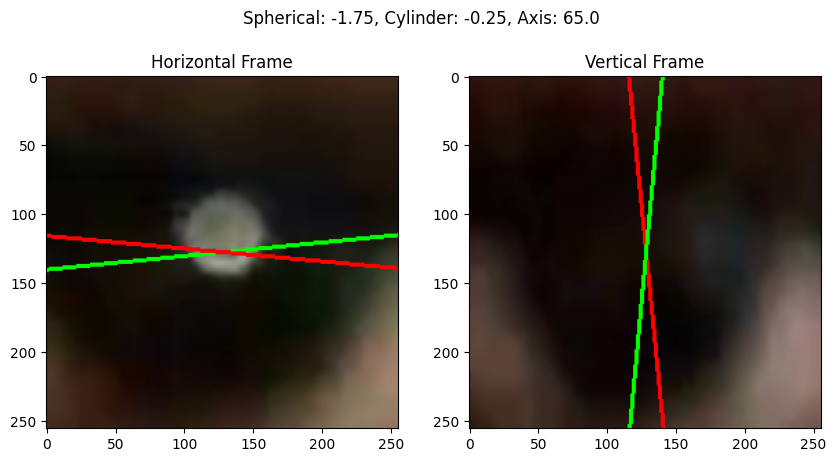

In [6]:
# select random row with no nan values
row = np.random.choice(df.dropna().index) # 287
n = 5
refraction = get_refraction(row)
sol = calculator.forward(refraction['sphere'], refraction['cylinder'], refraction['axis'])
print(sol)
deg_h = math.degrees(sol['gamma_h'])
deg_v = math.degrees(sol['gamma_v'])
print(deg_h)
print(deg_v)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# rotate horizontal frame by 90 degrees
h_frame = load_frame(row, 'horiz', n)
h_frame = cv2.rotate(h_frame, cv2.ROTATE_90_CLOCKWISE)
# draw a line in the middle of the frame at 30 degrees
h_frame = add_line(h_frame, deg_h, color=(0, 255, 0))
h_frame = add_line(h_frame, deg_v, color=(255, 0, 0))

plt.imshow(h_frame, cmap='gray')
plt.title('Horizontal Frame')
plt.subplot(1, 2, 2)

v_frame = load_frame(row, 'vert', n)
v_frame = add_line(v_frame, deg_h + 90, color=(255, 0, 0))
v_frame = add_line(v_frame, deg_v + 90, color=(0, 255, 0))

plt.imshow(v_frame, cmap='gray')
plt.title('Vertical Frame')
# show refraction data

plt.suptitle(f"Spherical: {refraction['sphere']}, Cylinder: {refraction['cylinder']}, Axis: {refraction['axis']}")
plt.show()